In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import sys
import math
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
"""
function to take in the path of a file of type jpeg or png and return an
image in byte scale 0,255. 
"""

def image_read(pathoffile):
    exten = pathoffile.split(".")[-1]
    
    if str(exten).upper() in ("JPG", "JPEG"):
        return mpimg.imread(pathoffile)
    elif str(exten).upper() == "PNG":
        return (mpimpg.imread(pathoffile)*255).astype('unit8')
    else:
        sys.exit("Wrong File")

In [3]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [4]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [5]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [6]:
def draw_lines2(img, lines, min_y, weight, color=[[255, 0, 0], [255,0 , 0]], thickness = 15):
    """This is an extension of the draw_lines function from the given blueprint.
    It draws left and right lane lines to both the images and the videos. """
    
    global lines_before, video_file
    
    line_left = []
    line_right = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = ((y2-y1)/(x2-x1))
            if (0.4<slope<1.0) or (-1.0<slope<-0.4):
                intercept = y1 - slope * x1
                length = math.sqrt((y2-y1)**2.0 + (x2-x1)**2.0)
                if slope > 0:
                    line_left.append((slope,intercept, length))
                elif slope < 0:
                    line_right.append((slope,intercept,length))
            else:
                pass
            
    line_left = np.array(line_left)
    line_left_slope = np.average(line_left[:,0], weights=line_left[:,2])
    line_left_intercept = np.average(line_left[:,1], weights=line_left[:,2])
    
    line_right=np.array(line_right)
    line_right_slope = np.average(line_right[:,0], weights=line_right[:,2])
    line_right_intercept = np.average(line_right[:,1], weights = line_right[:,2])
    
    
    if not lines_before:
        pass
    else:
        line_left_slope = weight*lines_before[0][0] + (1.0-weight) * line_left_slope
        line_left_intercept = weight*lines_before[0][1] + (1.0-weight)*line_left_intercept
        line_right_slope = weight*lines_before[1][0] + (1.0-weight) * line_right_slope
        line_right_intercept = weight * lines_before[1][1] + (1.0-weight) * line_right_intercept
        
        
    if video_file:
        lines_before = tuple(((line_left_slope, line_left_intercept),(line_right_slope, line_right_intercept)))
        
                        
    
    img_shape = img.shape
    
    y1_left = img_shape[0]
    x1_left = int((y1_left - line_left_intercept)/ line_left_slope)
    
    y2_left = min_y
    x2_left = int((y2_left - line_left_intercept)/ line_left_slope)
    
    y1_right = img_shape[0]
    x1_right = int((y1_right - line_right_intercept)/line_right_slope)
    
    y2_right = min_y
    x2_right = int((y2_right - line_right_intercept)/line_right_slope)
    
    cv2.line(img, (x1_left,y1_left), (x2_left, y2_left), color[0], thickness)
    cv2.line(img, (x1_right, y1_right), (x2_right, y2_right),color[1] ,thickness)
    

In [7]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

In [8]:
def hough_lines2(img, rho, theta, threshold, min_line_len, max_line_gap, min_y, weight):
    """
   this function uses the the same pipeline as hough_lines function however sends the 
   resulting image to draw_lines2 function to create a solid left and right lane line.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines2(line_img, lines, min_y, weight)
    return line_img

In [9]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
   

    # Convert to grayscale   
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) 
    
    
    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 3 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    
    # Define our parameters for Canny and run it
    low_threshold = 75
    high_threshold = 225
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    
    # Applying a mask for the region of intersect
    # This time we are defining a four sided polygon to mask
    min_y = 320
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(480,min_y), (490, min_y), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 15    # maximum gap in pixels between connectable line segments
    filter_weight = 0.75

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines1 = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Running new hough_lines2 function to get solid lane lines.
    lines2 = hough_lines2(masked_edges, rho, theta, threshold, min_line_length, max_line_gap,
                                           min_y, filter_weight)
    

    line_edges = weighted_img(lines1, image)
    line_edges_final = weighted_img(lines2, image)
    
    if not video_file:
        fig = plt.figure()
        x=fig.add_subplot(1,2,1)
        x.set_title("Orignal Lines")
        plt.imshow(line_edges)
        x=fig.add_subplot(1,2,2)
        x.set_title("Final Lines")
        plt.imshow(line_edges_final)
        plt.show()
        
    return line_edges_final

In [10]:
# Function to run pipeline for all the images in the test_images folder
def run():
   
    for name in os.listdir("test_images/"):
        folder_name = "test_images"
        path = folder_name + "/" + name
        image = image_read(path)
        
        print(name.upper())
        
        result = process_image(image)
        
        nm, ext = name.split(".")
        out_file_name = "Results/" + nm + "_out." + ext
        cv2.imwrite(out_file_name, cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

SOLIDWHITECURVE.JPG


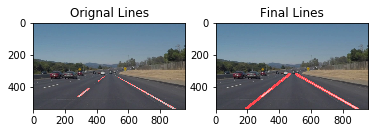

SOLIDWHITERIGHT.JPG


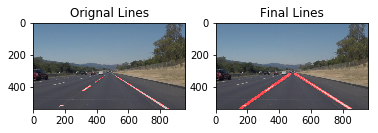

SOLIDYELLOWCURVE.JPG


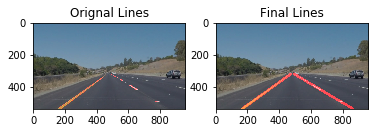

SOLIDYELLOWCURVE2.JPG


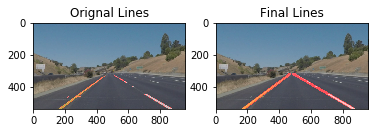

SOLIDYELLOWLEFT.JPG


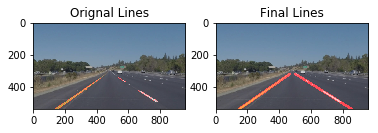

WHITECARLANESWITCH.JPG


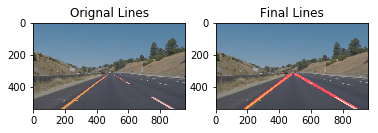

In [11]:
lines_before = []
video_file = False
run()

In [12]:
video_file = True

In [13]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 59.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 4.4 s


In [14]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [15]:
lines_before = []
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████▉| 681/682 [00:12<00:00, 55.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 13.1 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))